In [1]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 517 kB/s 


In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.utils import define_device
import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sns
import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Digital-Persona.csv')


In [5]:
if "Filename"  in train.columns:
    train.drop(["Filename"], axis = 1, inplace = True)

In [6]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingDigitalPersona.csv')

In [7]:
if "Filename"  in test.columns:
    test.drop(["Filename"], axis = 1, inplace = True)

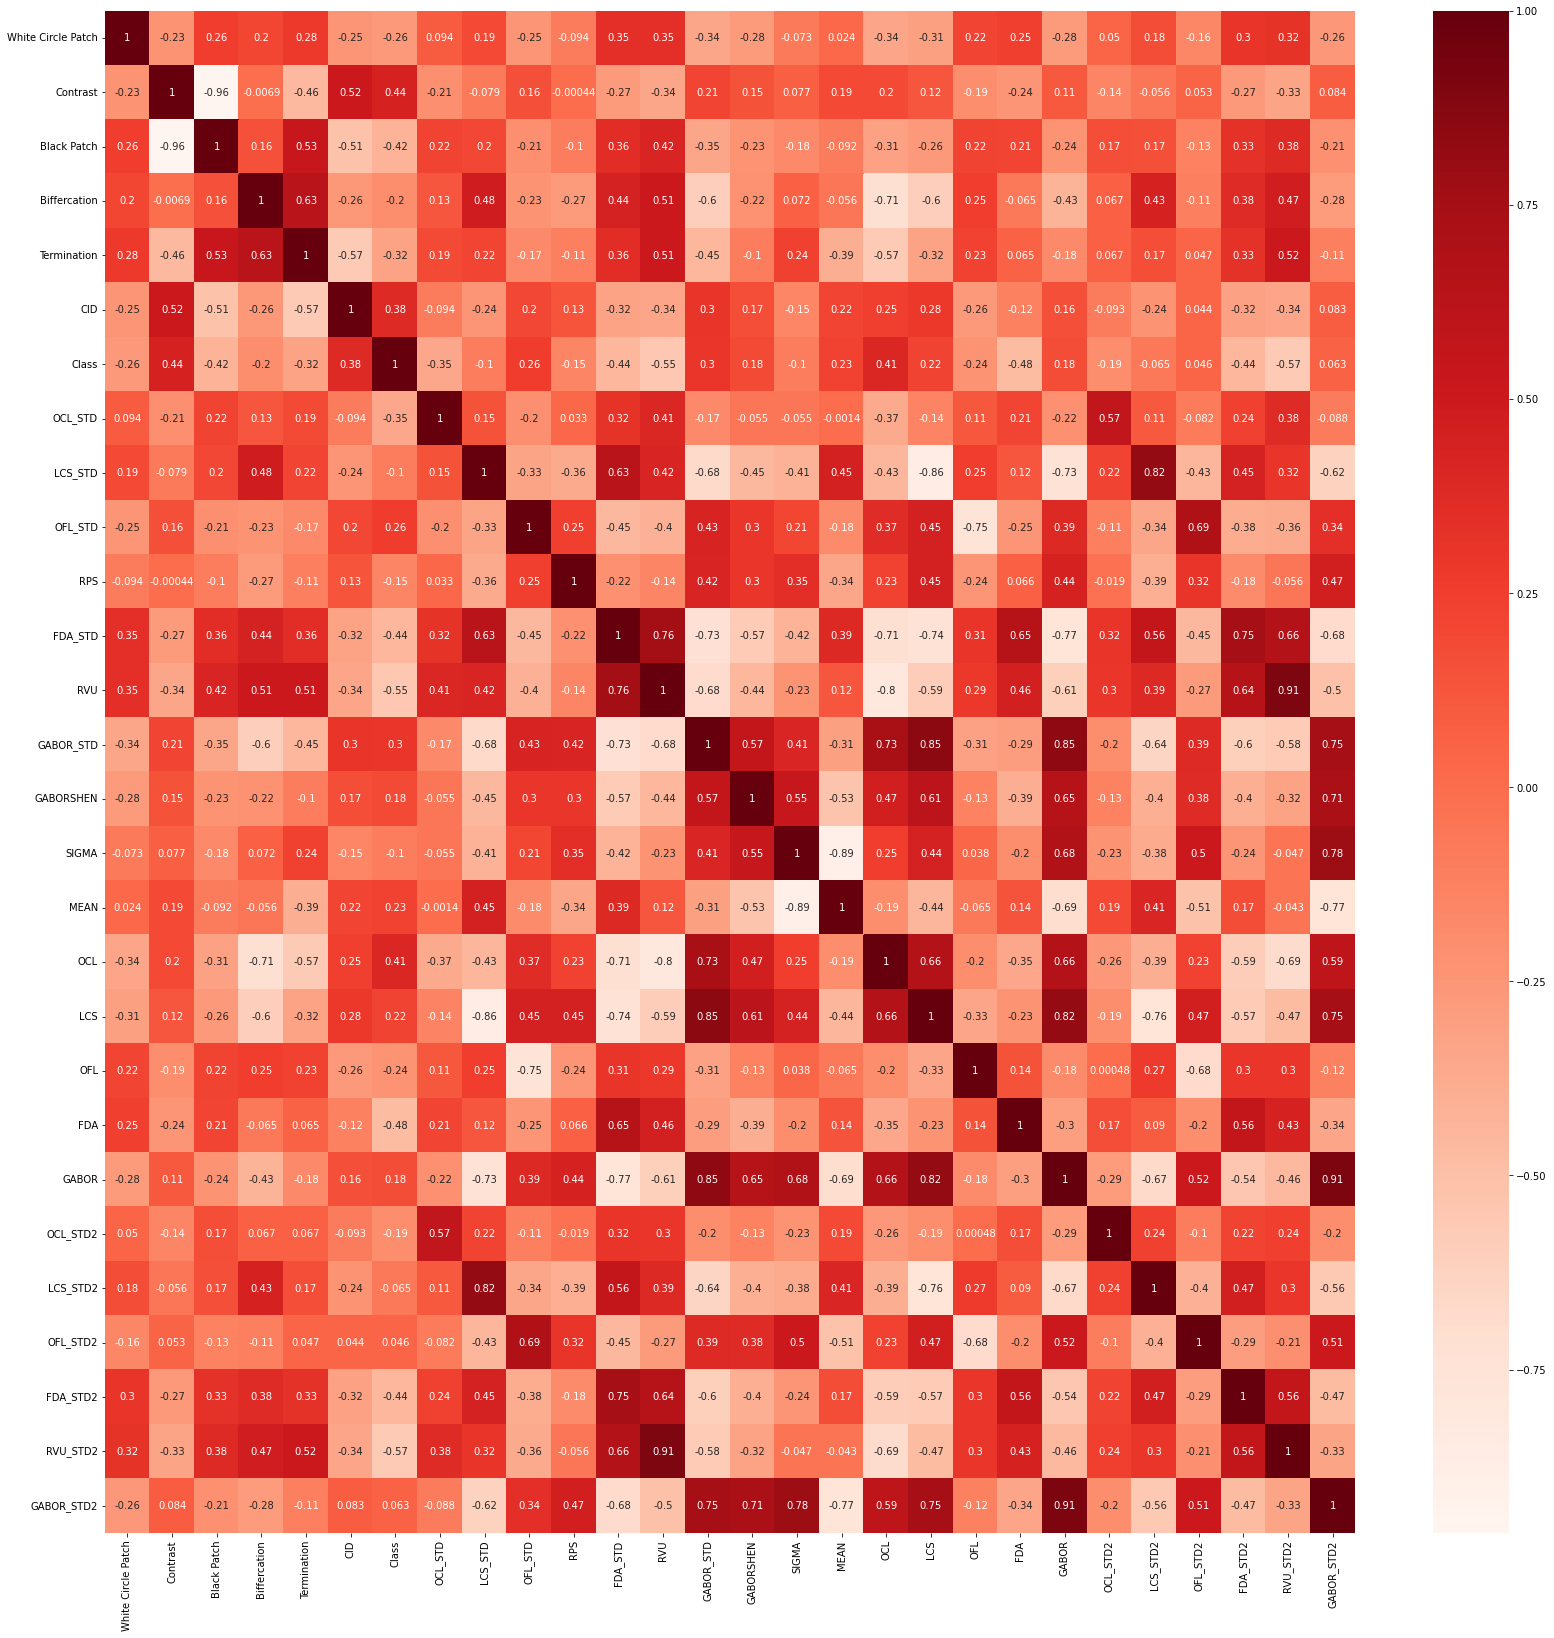

In [8]:
plt.figure(figsize=(28,28))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [9]:
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.4]
relevant_features

Contrast       0.440039
Black Patch    0.422241
Class          1.000000
FDA_STD        0.442349
RVU            0.548243
OCL            0.406305
FDA            0.477093
FDA_STD2       0.442347
RVU_STD2       0.568689
Name: Class, dtype: float64

In [10]:
#68%, 57%
#train = train[['White Circle Patch','Contrast','Black Patch','Termination','CID','Class','OCL_STD','OFL_STD','FDA_STD','RVU','GABOR_STD','MEAN','OCL','LCS','OFL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.2, 79%,62%
#train = train[['Contrast','Black Patch','Termination','CID','Class','OCL_STD','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.3,90%,80%
train = train[['Contrast','Black Patch','Class','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.4, 88%, 84%

In [11]:
#test = test[['White Circle Patch','Contrast','Black Patch','Termination','CID','Class','OCL_STD','OFL_STD','FDA_STD','RVU','GABOR_STD','MEAN','OCL','LCS','OFL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.2
#test = test[['Contrast','Black Patch','Termination','CID','Class','OCL_STD','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.3
test = test[['Contrast','Black Patch','Class','FDA_STD','RVU','OCL','FDA','FDA_STD2','RVU_STD2']].copy() #>=0.4

In [12]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))
#train["Set"] = "train"    
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [13]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [14]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Class 2
Set 2


In [15]:
train.head()

Contrast  Black Patch  Class   FDA_STD       RVU       OCL       FDA  \
0  0.192565     0.965358      1  0.176037  0.353598  0.710952  0.487488   
1  0.184950     0.967039      1  0.154466  0.331051  0.777803  0.502754   
2  0.187642     0.966452      1  0.183331  0.584087  0.716943  0.484818   
3  0.177059     0.969040      1  0.186131  0.417190  0.742284  0.448238   
4  0.185612     0.966522      1  0.171876  0.375148  0.790276  0.462497   

   FDA_STD2  RVU_STD2  Set  
0  0.095556  0.143455    0  
1  0.092978  0.107935    0  
2  0.120344  0.268805    0  
3  0.156784  0.182722    0  
4  0.112946  0.144860    0

In [16]:
nunique = test.nunique()
types = test.dtypes
for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)

    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Class 2
Set 1


In [17]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [18]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [19]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [20]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]


In [21]:
X_train[0]

array([0.19256475, 0.96535815, 0.17603729, 0.35359804, 0.71095223,
       0.48748848, 0.09555587, 0.14345473])

In [22]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [23]:
class ClassificationSMOTE():
    """
    Apply SMOTE for classification tasks.
    This will average a percentage p of the elements in the batch with other elements.
    The target will stay unchanged and keep the value of the most important row in the mix.
    """
    def __init__(self, device_name="auto", p=0.8, alpha=0.5, beta=0.5, seed=0):
        ""
        self.seed = seed
        self._set_seed()
        self.device = define_device(device_name)
        self.alpha = alpha
        self.beta = beta
        self.p = p
        if (p < 0.) or (p > 1.0):
            raise ValueError("Value of p should be between 0. and 1.")

    def _set_seed(self):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        return

    def __call__(self, X, y):
        batch_size = X.shape[0]
        random_values = torch.rand(batch_size, device=self.device)
        idx_to_change = random_values < self.p

        # ensure that first element to switch has probability > 0.5
        np_betas = np.random.beta(self.alpha, self.beta, batch_size) / 2 + 0.5
        random_betas = torch.from_numpy(np_betas).to(self.device).float()
        index_permute = torch.randperm(batch_size, device=self.device)

        X[idx_to_change] = random_betas[idx_to_change, None] * X[idx_to_change]
        X[idx_to_change] += (1 - random_betas[idx_to_change, None]) * X[index_permute][idx_to_change].view(X[idx_to_change].size())  # noqa

        return X, y

In [24]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [25]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug,#aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 1.09697 | train_auc: 0.6577  | valid_auc: 0.71238 |  0:00:00s
epoch 1  | loss: 0.64308 | train_auc: 0.23874 | valid_auc: 0.2554  |  0:00:00s
epoch 2  | loss: 0.51297 | train_auc: 0.25517 | valid_auc: 0.24643 |  0:00:00s
epoch 3  | loss: 0.46338 | train_auc: 0.26048 | valid_auc: 0.25373 |  0:00:00s
epoch 4  | loss: 0.43124 | train_auc: 0.28988 | valid_auc: 0.29057 |  0:00:00s
epoch 5  | loss: 0.43587 | train_auc: 0.32498 | valid_auc: 0.32967 |  0:00:00s
epoch 6  | loss: 0.41943 | train_auc: 0.36836 | valid_auc: 0.37978 |  0:00:01s
epoch 7  | loss: 0.39221 | train_auc: 0.46225 | valid_auc: 0.49848 |  0:00:01s
epoch 8  | loss: 0.39963 | train_auc: 0.53451 | valid_auc: 0.5742  |  0:00:01s
epoch 9  | loss: 0.40425 | train_auc: 0.58872 | valid_auc: 0.62338 |  0:00:01s
epoch 10 | loss: 0.39551 | train_auc: 0.60178 | valid_auc: 0.63494 |  0:00:01s
epoch 11 | loss: 0.36803 | train_auc: 0.60845 | valid_auc: 0.63678 |  0:00:01s
epoch 12 | loss: 0.36245 | train_auc: 0.6186  | vali

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 1  | loss: 0.64308 | train_auc: 0.23874 | valid_auc: 0.2554  |  0:00:00s
epoch 2  | loss: 0.51297 | train_auc: 0.25517 | valid_auc: 0.24643 |  0:00:00s
epoch 3  | loss: 0.46338 | train_auc: 0.26048 | valid_auc: 0.25373 |  0:00:00s
epoch 4  | loss: 0.43124 | train_auc: 0.28988 | valid_auc: 0.29057 |  0:00:00s
epoch 5  | loss: 0.43587 | train_auc: 0.32498 | valid_auc: 0.32967 |  0:00:00s
epoch 6  | loss: 0.41943 | train_auc: 0.36836 | valid_auc: 0.37978 |  0:00:00s
epoch 7  | loss: 0.39221 | train_auc: 0.46225 | valid_auc: 0.49848 |  0:00:00s
epoch 8  | loss: 0.39963 | train_auc: 0.53451 | valid_auc: 0.5742  |  0:00:01s
epoch 9  | loss: 0.40425 | train_auc: 0.58872 | valid_auc: 0.62338 |  0:00:01s
epoch 10 | loss: 0.39551 | train_auc: 0.60178 | valid_auc: 0.63494 |  0:00:01s
epoch 11 | loss: 0.36803 | train_auc: 0.60845 | valid_auc: 0.63678 |  0:00:01s
epoch 12 | loss: 0.36245 | train_auc: 0.6186  | valid_auc: 0.6445  |  0:00:01s
epoch 13 | loss: 0.38302 | train_auc: 0.60171 | vali

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


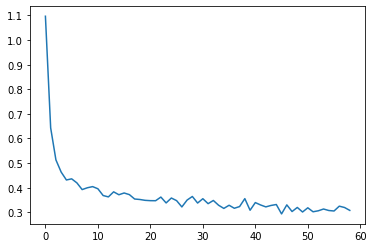

In [26]:
plt.plot(clf.history['loss'])

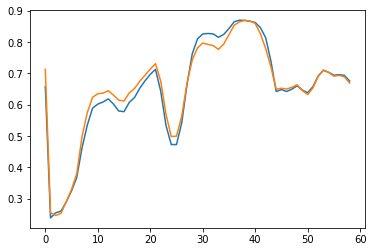

In [27]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

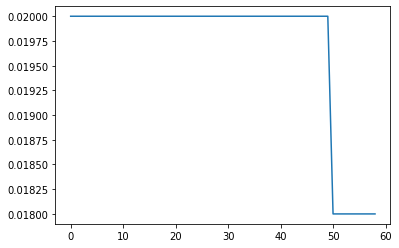

In [28]:
plt.plot(clf.history['lr'])

In [29]:
features

['Contrast',
 'Black Patch',
 'FDA_STD',
 'RVU',
 'OCL',
 'FDA',
 'FDA_STD2',
 'RVU_STD2']

In [30]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.8686738964992389
FINAL TEST SCORE : 0.8142123225369843


In [31]:
clf.predict(X_test)

array(['classZero', 'classZero', 'classZero', ..., 'classZero',
       'classZero', 'classZero'], dtype='<U9')

In [32]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [33]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [34]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.8142123225369843


In [35]:
assert(test_auc == loaded_test_auc)

In [36]:
loaded_clf.predict(X_test)

array(['classZero', 'classZero', 'classZero', ..., 'classZero',
       'classZero', 'classZero'], dtype='<U9')

In [37]:
clf.feature_importances_

array([0.20327269, 0.11083536, 0.01987213, 0.04636253, 0.23717969,
       0.1582676 , 0.01638742, 0.20782259])

In [38]:
explain_matrix, masks = clf.explain(X_test)

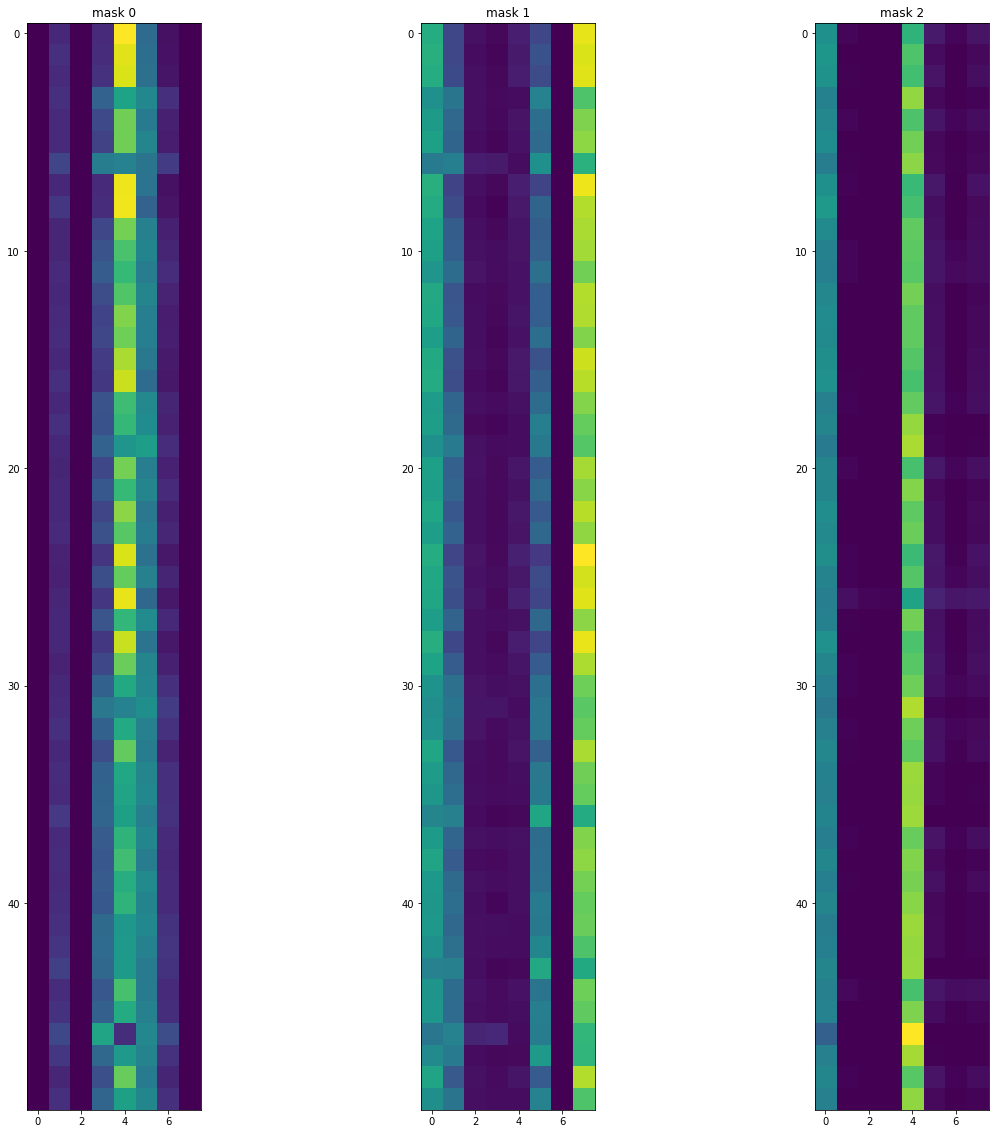

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")